In [1]:
import os
import pandas as pd
import numpy as np
# from scipy.signal import medfilt
import sys
import matplotlib.pyplot as plt


In [2]:

def get_data(file):
    # loc = args["data_loc"]

    try:
        data = pd.read_excel(file)
    except:
        try:
            data = pd.read_csv(file)
        except Exception as e:
            raise e
    data.columns = [
        "Timestamp",
        "QuaternionX",
        "QuaternionY",
        "QuaternionZ",
        "QuaternionW",
        "AttitudePitch",
        "AttitudeRoll",
        "AttitudeYaw",
        "GravitationalAccelerationX",
        "GravitationalAccelerationY",
        "GravitationalAccelerationZ",
        "AccelerationX",
        "AccelerationY",
        "AccelerationZ",
        "RotationX",
        "RotationY",
        "RotationZ",
    ]
    # print("data", data.shape)
    # print("data col", data.columns)
    # _, sr = get_sampling_rate(data)
    # print("sr", sr)
    accel_data = data[["AccelerationX", "AccelerationY", "AccelerationZ"]]
    # print(accel_data.shape)
    # filtered_data = butter_lowpass_filter(accel_data, 50, 97, 6)
    accel_data = np.array(accel_data)
    # filtered_data = butter_highpass_filter(accel_data, 0.05, 97)
    # accel_data = filtered_data
    return accel_data

In [3]:
def plot_accel_magnitude(accel_data, sampling_rate=25):
    """
    Plot the magnitude of acceleration from a numpy array.
    
    Parameters:
        accel_data (np.ndarray): Nx3 array where columns are [x, y, z] acceleration.
        sampling_rate (int): Samples per second (Hz).
    """
    if accel_data.shape[1] != 3:
        raise ValueError("Input array must have 3 columns for x, y, z acceleration.")

    # Compute magnitude
    magnitude = np.linalg.norm(accel_data, axis=1)

    # Create time axis
    time = np.arange(len(magnitude)) / sampling_rate

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, magnitude, label='Accel Magnitude', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Magnitude (m/s²)')
    plt.title('Acceleration Magnitude Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


tanvi_walking_window_1.csv


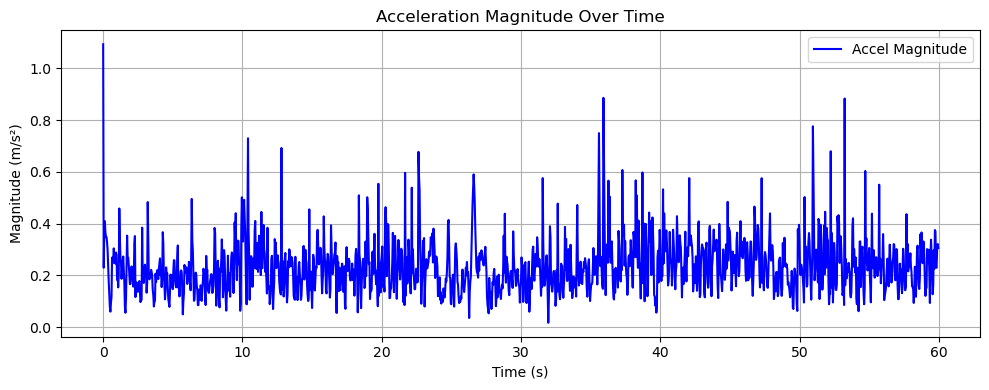

tanvi_walking_window_2.csv


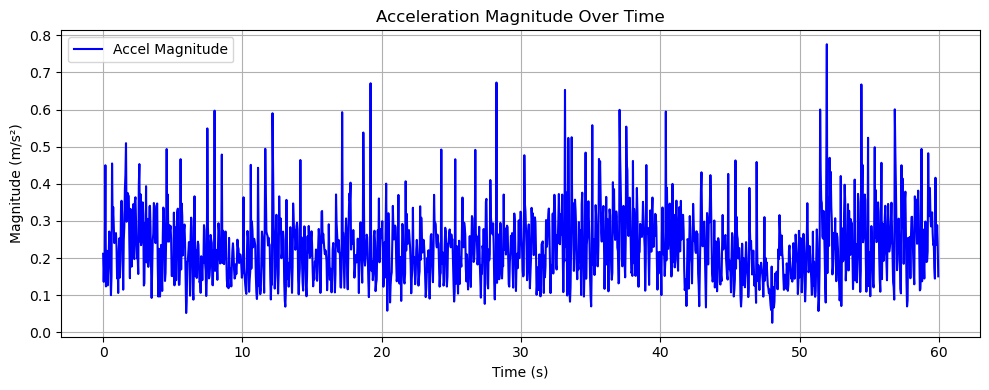

tanvi_walking_window_3.csv


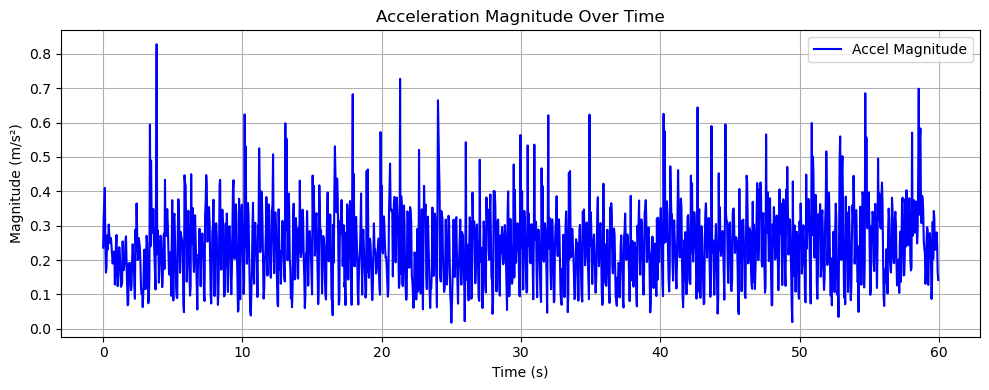

tanvi_walking_window_4.csv


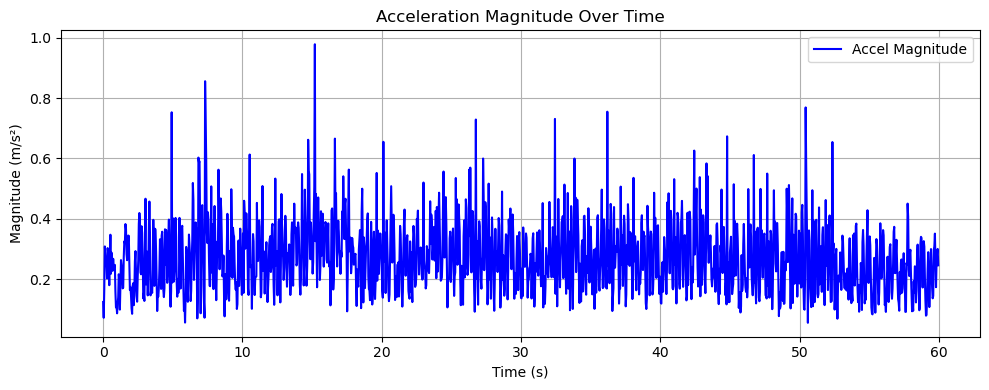

tanvi_walking_window_5.csv


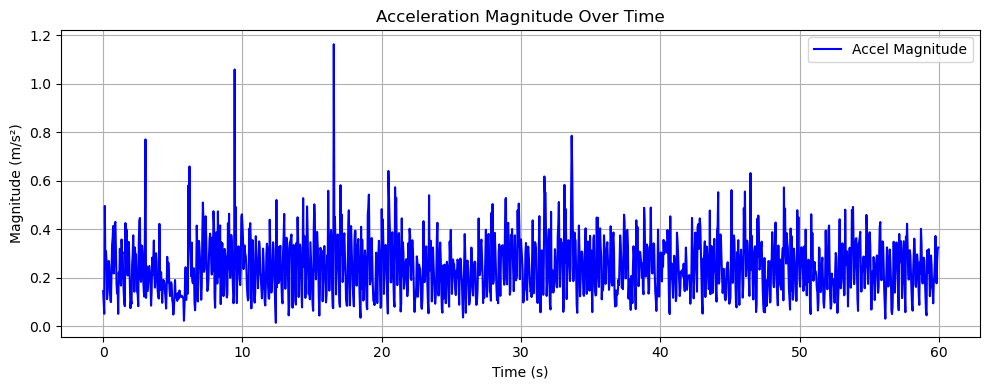

tanvi_walking_window_6.csv


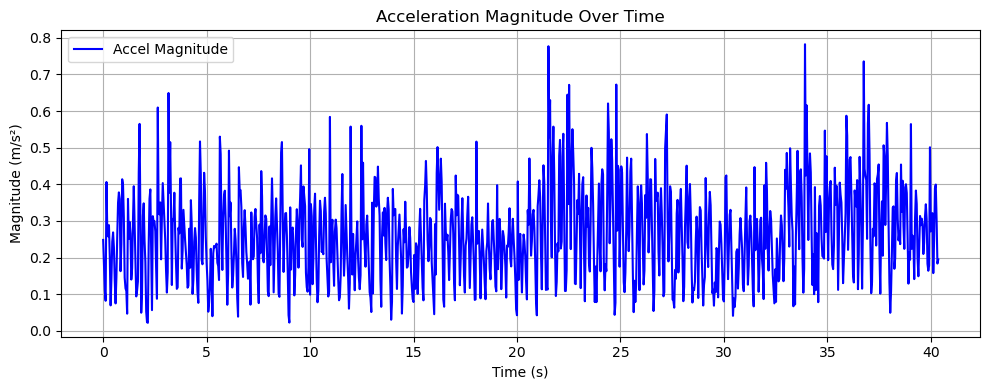

In [4]:
 # input_csv_file = sys.argv[1]
for file in os.listdir("tanvi_walking"):
    print(file)
    accel_data = get_data("tanvi_walking/" + file)
    plot_accel_magnitude(accel_data, 25)


In [9]:
from scipy.signal import find_peaks

def estimate_steps(accel_data, sampling_rate=25, plot=False):
    """
    Estimate number of steps from acceleration data.

    Parameters:
        accel_data (np.ndarray): Nx3 array of [x, y, z] acceleration.
        sampling_rate (int): Sampling rate in Hz.
        plot (bool): If True, plot acceleration magnitude with detected peaks.

    Returns:
        int: Estimated number of steps.
    """
    if accel_data.shape[1] != 3:
        raise ValueError("Input array must have 3 columns for x, y, z acceleration.")

    # 1. Compute magnitude
    magnitude = np.linalg.norm(accel_data, axis=1)

    # 2. Optional: smooth the signal (moving average filter)
    window_size = int(0.1 * sampling_rate)  # 200 ms window
    smooth_magnitude = np.convolve(magnitude, np.ones(window_size)/window_size, mode='same')

    # 3. Find peaks (each peak = 1 step)
    peaks, _ = find_peaks(smooth_magnitude, distance=sampling_rate*0.1, height=0.5*np.mean(smooth_magnitude))
    # print(peaks)
    if plot:
        time = np.arange(len(magnitude)) / sampling_rate
        plt.figure(figsize=(10, 4))
        plt.plot(time, smooth_magnitude, label='Smoothed Accel Magnitude')
        plt.plot(time[peaks], smooth_magnitude[peaks], 'ro', label='Detected Steps')
        plt.xlabel('Time (s)')
        plt.ylabel('Accel Magnitude')
        plt.title('Step Estimation')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return len(peaks)


In [10]:
from scipy import signal, integrate

def estimate_speed_x(accel_data, sampling_rate=25, plot=True):
    """
    Estimate the speed in the x-direction by integrating the x-component of the acceleration.

    Parameters:
        accel_data (np.ndarray): Nx3 array of [x, y, z] acceleration.
        sampling_rate (int): Sampling rate in Hz.

    Returns:
        np.ndarray: Estimated speed in the x-direction (1D array) over time.
    """
    # Extract the x-component of acceleration (assuming accel_data is Nx3)
    accel_x = np.linalg.norm(accel_data[:, :1], axis=1)  # First column corresponds to x-component of acceleration
    print("accel", accel_data[:, :1].shape)
    # Calculate dt (time step between samples)
    dt = 1 / sampling_rate  # Time step in seconds

    # Integrate the x-component to get velocity in the x-direction
    velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)

    # 5. Smooth velocity (optional)
    velocity = signal.medfilt(velocity_x, kernel_size=5)
    # velocity = np.maximum(velocity, 0)  # remove negative values

    if plot:
        import matplotlib.pyplot as plt
        time = np.arange(len(velocity)) / sampling_rate
        plt.figure(figsize=(10, 4))
        plt.plot(time, velocity, label='Estimated Speed (m/s)', color='green')
        plt.xlabel('Time (s)')
        plt.ylabel('Speed (m/s)')
        plt.title('Estimated Running Speed from Acceleration')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return velocity


In [7]:
import math
def to_pace_time(pace):
    tempPace = pace
    tempPace = tempPace * 2.23694
    if tempPace == 0:
        tempPace = 0.0001
    tempPace = tempPace * 2.23694
    tempPace = 60 / tempPace
    return tempPace

to_pace_time(math.sqrt(0.1 ** 2 + 0.4 ** 2+ 0.2 **2))

26.165734605924854

tanvi_04_07_19_45_47_window_1.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


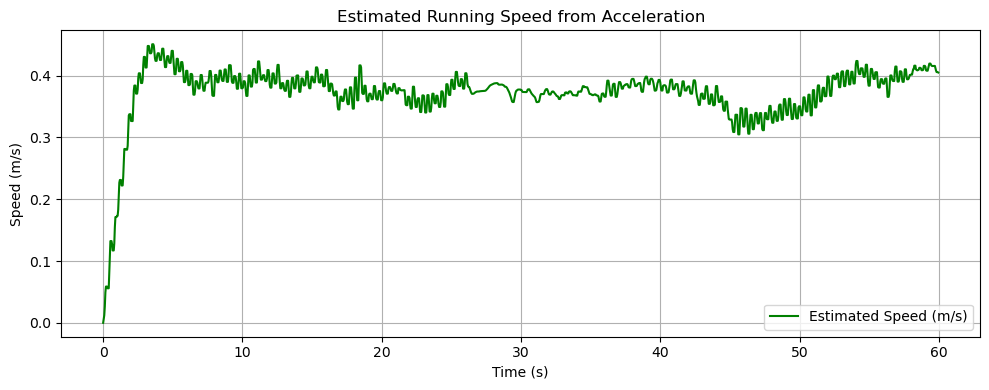

tanvi_04_07_19_45_47_window_10.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


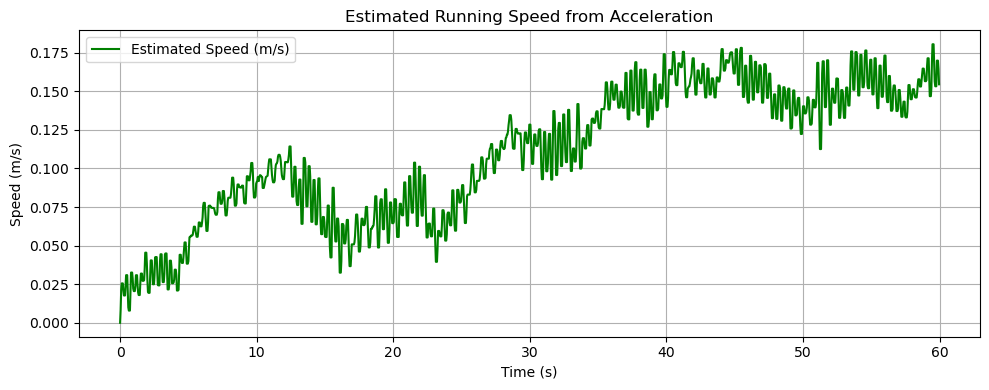

tanvi_04_07_19_45_47_window_11.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


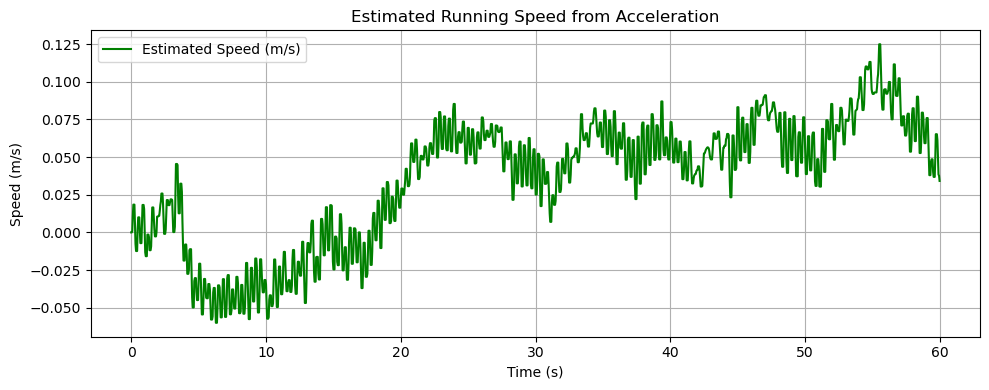

tanvi_04_07_19_45_47_window_12.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


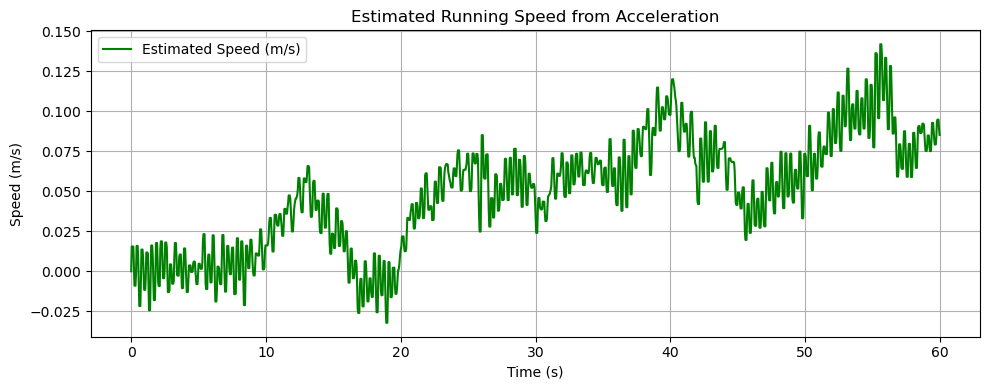

tanvi_04_07_19_45_47_window_13.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


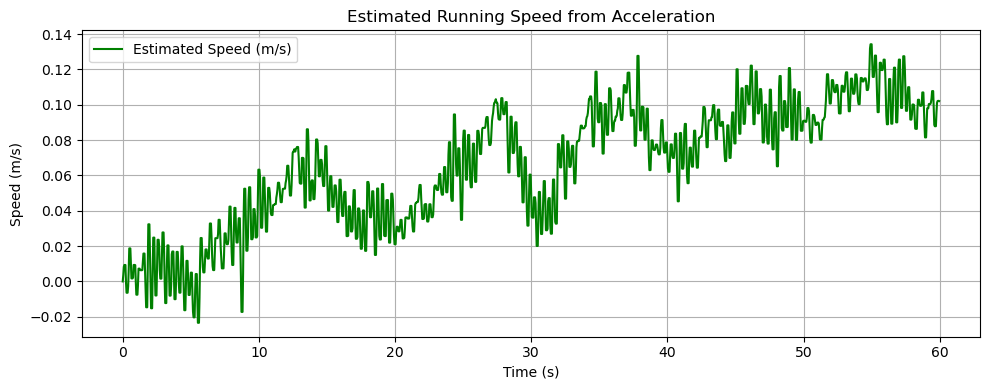

tanvi_04_07_19_45_47_window_14.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


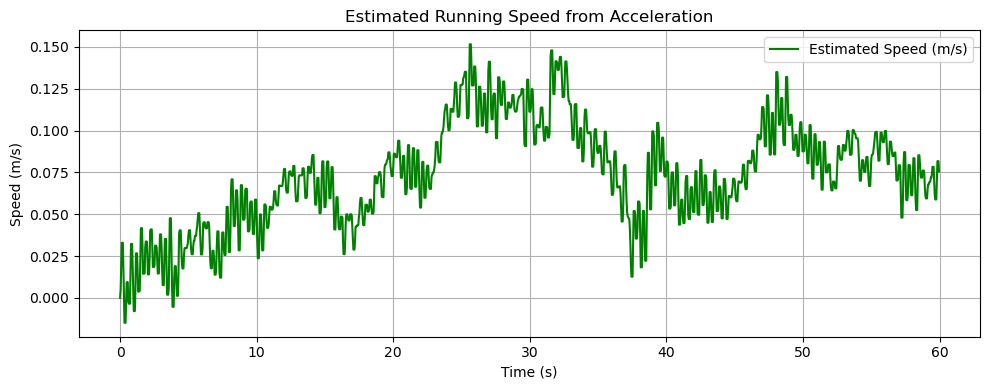

C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


tanvi_04_07_19_45_47_window_15.csv
accel (1500, 1)


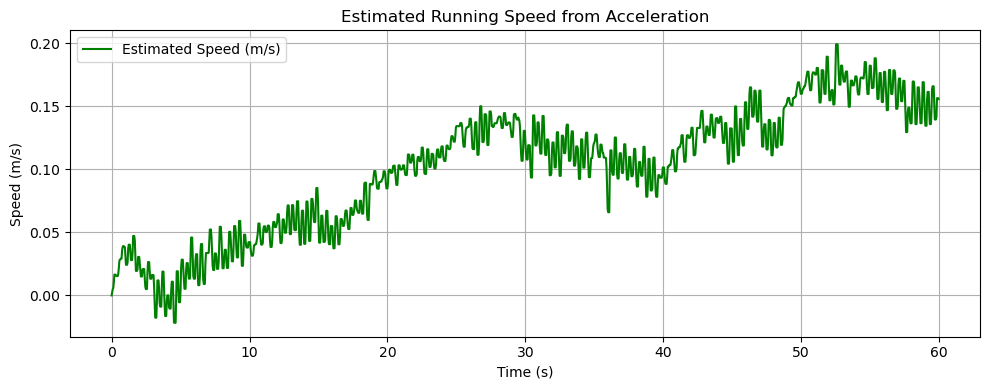

tanvi_04_07_19_45_47_window_16.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


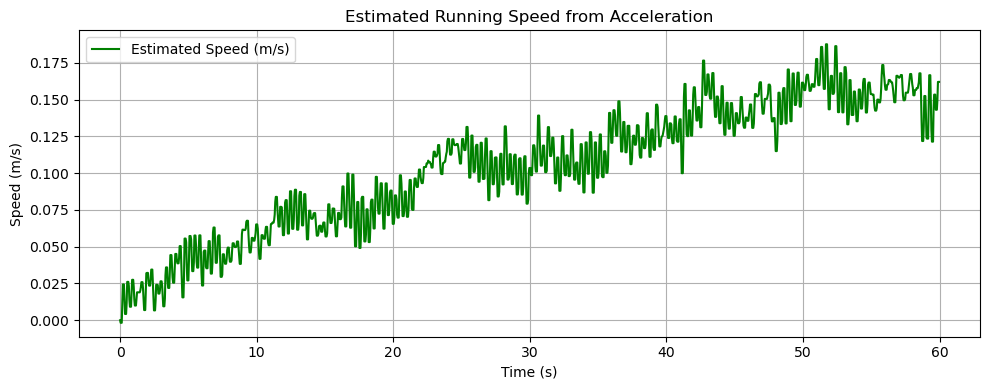

tanvi_04_07_19_45_47_window_17.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


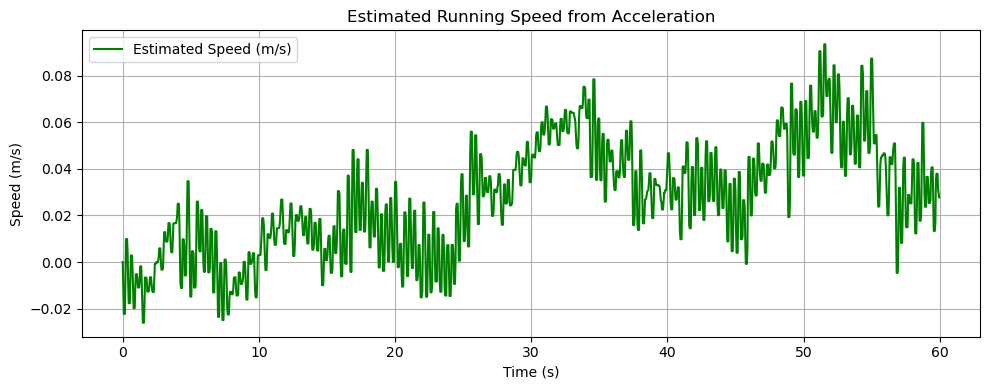

tanvi_04_07_19_45_47_window_18.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


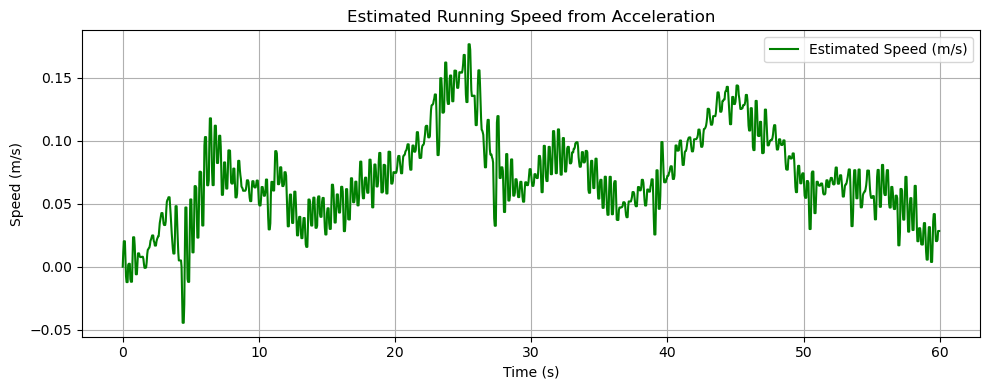

tanvi_04_07_19_45_47_window_19.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


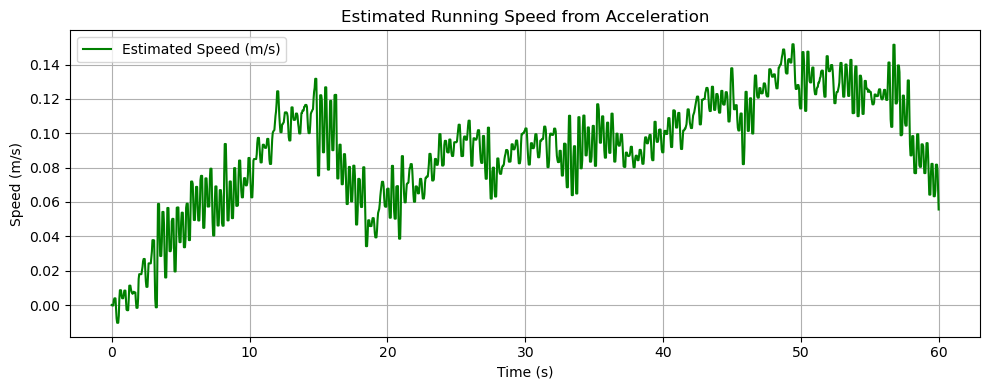

tanvi_04_07_19_45_47_window_2.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


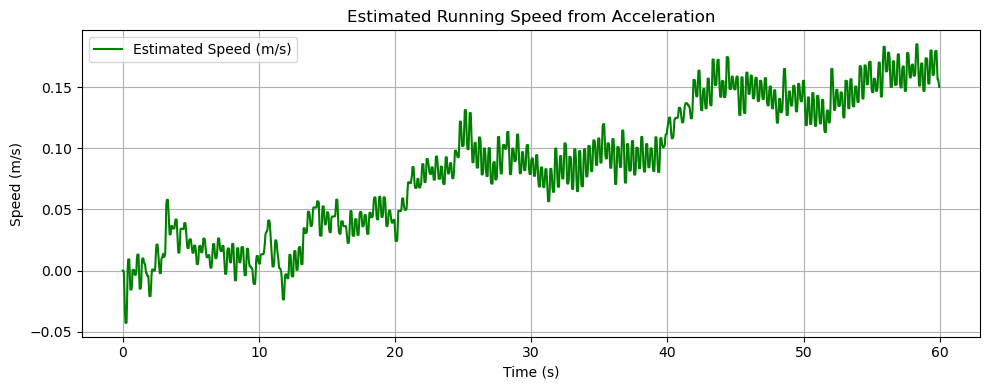

tanvi_04_07_19_45_47_window_20.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


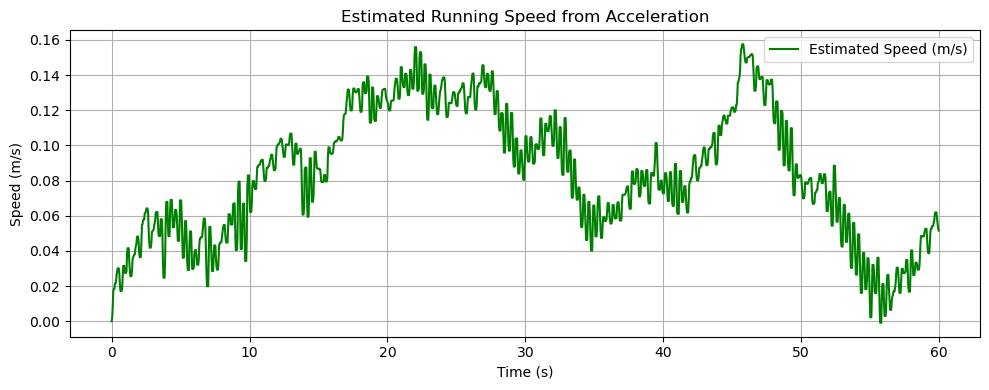

tanvi_04_07_19_45_47_window_21.csv
accel (1354, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


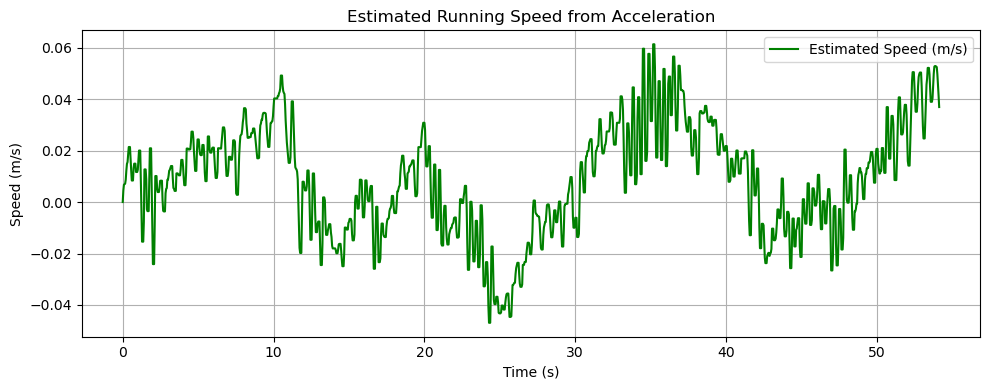

tanvi_04_07_19_45_47_window_3.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


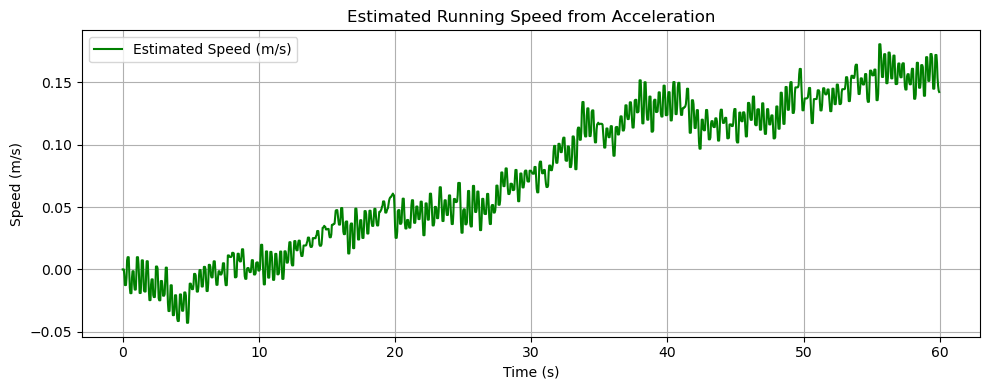

tanvi_04_07_19_45_47_window_4.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


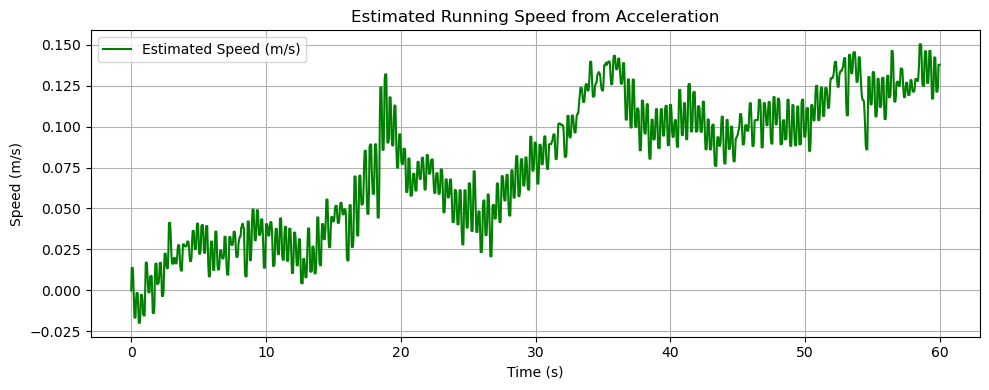

tanvi_04_07_19_45_47_window_5.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


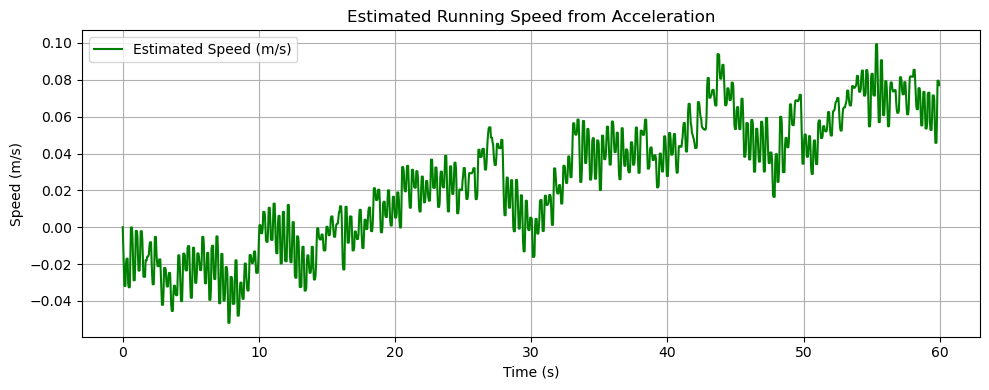

tanvi_04_07_19_45_47_window_6.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


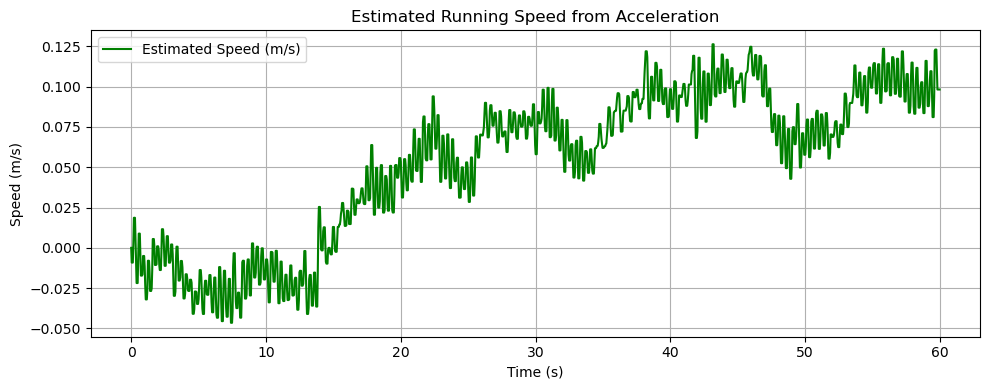

tanvi_04_07_19_45_47_window_7.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


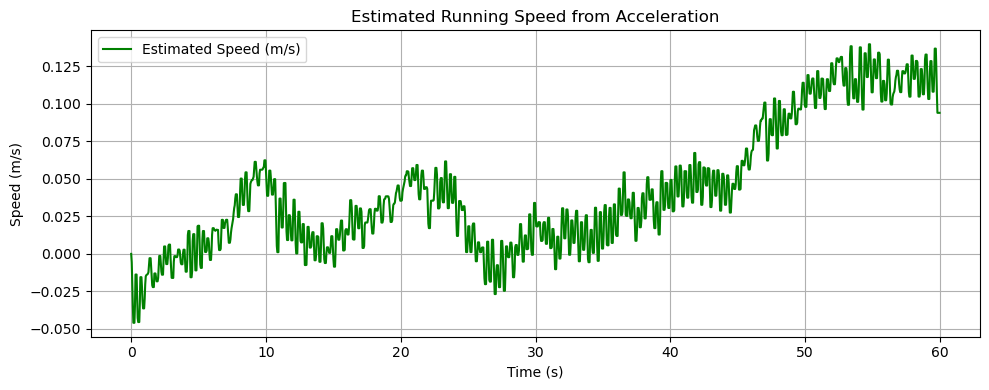

tanvi_04_07_19_45_47_window_8.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


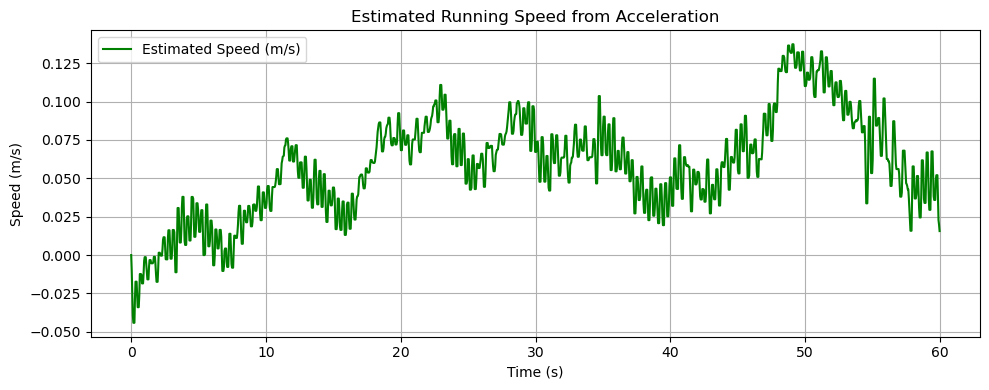

tanvi_04_07_19_45_47_window_9.csv
accel (1500, 1)


C:\Users\Elizabeth\AppData\Local\Temp\ipykernel_20080\542513669.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = integrate.cumtrapz(accel_data[:, 1], dx=dt, initial=0)


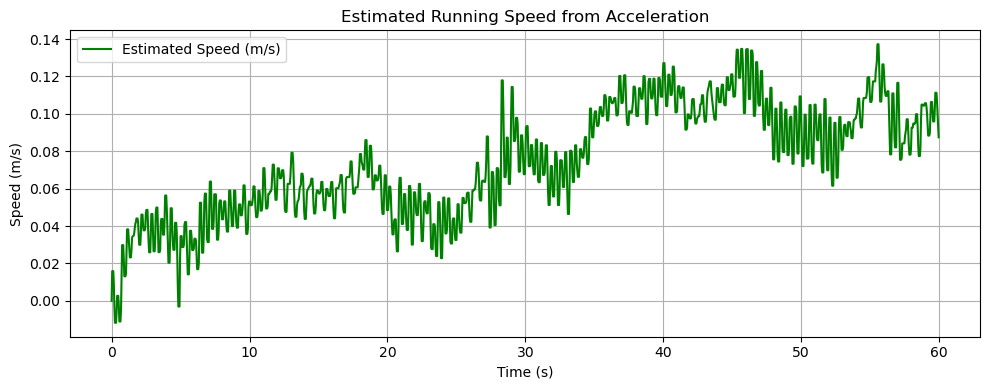

In [13]:
for file in os.listdir("tanvi_running/"):
    print(file)
    accel_data = get_data("tanvi_running/" + file)
    estimate_speed_x(accel_data, 25, plot=True)
# print(f"Estimated number of steps: {num_steps}")
